# <font color='red'>Task 1 : Apply clustering algorithm to group similar actors</font>

 1. For this task consider only the actor nodes 
 2. Apply any clustering algorithm of your choice <br>
    Refer : https://scikit-learn.org/stable/modules/clustering.html
 3. Choose the number of clusters for which you have maximum score of <b>$Cost1*Cost2$</b><br>
 4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 
<br> (Write your code in <font color='blue'>def cost1()</font>)<br>
 5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
 <br> (Write your code in <font color='blue'>def cost2()</font>)<br>
 6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
 7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction techniques (preferably TSNE)<br>
 8. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color

<img src='https://i.imgur.com/4SPYPFa.jpg'>

# <font color='red'>Task 2 : Apply clustering algorithm to group similar movies</font>


1. For this task consider only the movie nodes
2. Apply any clustering algorithm of your choice
3.Choose the number of clusters for which you have maximum score of $Cost1*Cost2$ <br>

    Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br>
(Write your code in <font color='blue'>def cost1()</font>)<br>
	
4. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
where N= number of clusters 
<br>(Write your code in <font color='blue'>def cost2()</font>)<br>


**Algorithm for actor nodes**

<br>

In [ ]:
!pip install networkx==2.3

In [ ]:
!pip install stellargraph

In [ ]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# you need to have tensorflow 
from stellargraph import StellarGraph
from stellargraph.data import UniformRandomMetaPathWalk
from sklearn.cluster import KMeans

In [ ]:
data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [ ]:
data.shape

(9650, 2)

In [ ]:
data.head(5)

,movie,actor
0,m1,a1
1,m2,a1
2,m2,a2
3,m3,a1
4,m3,a3


In [ ]:
edges = [tuple(x) for x in data.values.tolist()]
#print(edges)

In [ ]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')
#nx.draw_networkx(B,node_color='lightGreen')

In [ ]:
A = list(nx.connected_component_subgraphs(B))[0]
#nx.draw_networkx(A,node_color='lightGreen')

In [ ]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


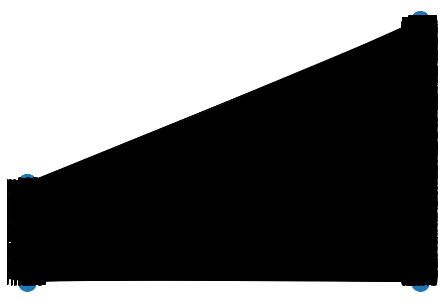

In [ ]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [ ]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [ ]:

# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)

In [ ]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [ ]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word 
 # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.node[node_id]['label'] for node_id in node_ids]
print(node_embeddings)

[[-1.4845178  -1.0050808  -0.26249182 ... -0.58109444  1.7452499
  -0.05382463]
 [ 0.41034028  0.40689194  2.1200671  ... -0.84377766  2.0243032
  -0.76217806]
 [-1.3126643  -1.0627904   0.9523361  ... -0.90337425  1.3816406
   0.20125742]
 ...
 [ 0.00755652 -0.04364604  0.02155663 ...  0.06443908 -0.06181733
   0.03068391]
 [-0.07148496  0.03630157  0.0204858  ...  0.02303072 -0.063368
   0.05701672]
 [-0.03724595  0.02608922  0.01341114 ...  0.03756592 -0.0551954
   0.00663832]]


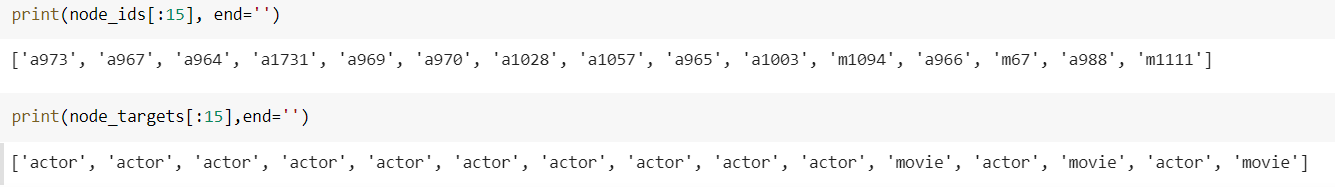

In [ ]:
def split_embedding(node_targets,node_embeddings):
  actor_embeddings=[]
  movie_embeddings=[]
  for i in range(len(node_ids)):
    if node_targets[i]=='actor':
      actor_embeddings.append(node_embeddings[i])
    else:
      movie_embeddings.append(node_embeddings[i])

  return actor_embeddings,movie_embeddings
#split_embedding(node_targets,node_embeddings)

In [ ]:
def split_nodes(node_ids):
  movie_nodes = []
  actor_nodes = []
  for i in node_ids:
      if 'm' in i:
          movie_nodes.append(i)
      if 'a' in i:
          actor_nodes.append(i)

  return actor_nodes,movie_nodes

In [ ]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=split_nodes(node_ids)
    actor_embeddings,movie_embeddings=split_embedding(node_targets,node_embeddings)
    # split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids
    # By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
    # By using node_ids and node_targets, we can extract actor_nodes and movie nodes

    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings=data_split(node_ids,node_targets,node_embeddings)

<font color='cyan'>Grader function - 1</font>

In [ ]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(actor_nodes)

True

<font color='cyan'>Grader function - 2</font>

In [ ]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

True

<font color='orange'>Calculating cost1</font>

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

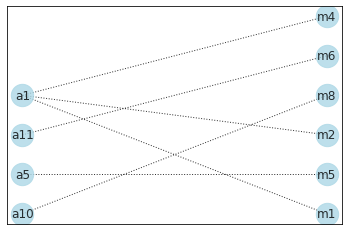

In [ ]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0, label='actor') # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1, label='movie')
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

In [ ]:
def cost1(graph,number_of_clusters):
  h = list(nx.connected_component_subgraphs(graph))
  t=len(h)
  degree=[]
  for i in range(t):
    su_graph=list(nx.connected_component_subgraphs(graph))[i]
    degree.append(su_graph.number_of_nodes())
  s=max(degree)
  f=graph.number_of_nodes()
  cost1=(1/number_of_clusters)*(s/f)
  return cost1

<font color='cyan'>Grader function - 3</font>

In [ ]:
graded_cost1=cost1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

<font color='orange'>Calculating cost2</font>

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

In [ ]:
def cost2(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    t=graph.number_of_edges()
    actor_nodes,movie_nodes=split_nodes(list(graph.nodes()))
    length=len(movie_nodes)
    cost2=(1/number_of_clusters)*(t/length) # calculate cost1 
    
    return cost2

<font color='cyan'>Grader function - 4</font>

In [ ]:
graded_cost2=cost2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

True

<font color='orange'>Grouping similar actors</font>

In [ ]:
# reference from applied ai course email reply
cost=[]
k=[3, 5, 10, 30, 50, 100, 200, 500]
for i in k:
  est=KMeans(n_clusters=i).fit(np.array(actor_embeddings))
  cost1_cl=0
  cost2_cl=0
  for j in range(est.n_clusters):
    # Getting actor nodes at each cluster
    clus_act=np.take(actor_nodes, np.where(est.labels_==j)[0])
    G=nx.Graph()    # empty graph 
    for act in clus_act:
      sub_gr=nx.ego_graph(A, act)
      G.add_nodes_from(sub_gr.nodes)
      G.add_edges_from(sub_gr.edges())
    #nx.draw_networkx(G,node_color='red')
    cost1_cl+=cost1(G, i)
    cost2_cl+=cost2(G, i)
    cost_t=cost1_cl*cost2_cl
  cost.append(cost_t)
print(cost)

[3.71265851297973, 2.925198154483404, 2.369813428588712, 1.753160872998939, 1.5208153291681012, 1.6703965407970611, 1.6555727771840547, 1.7750416353847425]


In [ ]:
max(cost)

3.71265851297973

In [ ]:
optimal_cluster=3
est=KMeans(n_clusters=optimal_cluster).fit(np.array(actor_embeddings))
p=est.labels_

<font color='orange'>Displaying similar actor clusters</font>

In [ ]:
from sklearn.manifold import TSNE
transform = TSNE #PCA

trans = transform(n_components=2)
actor_embeddings_2d = trans.fit_transform(actor_embeddings)

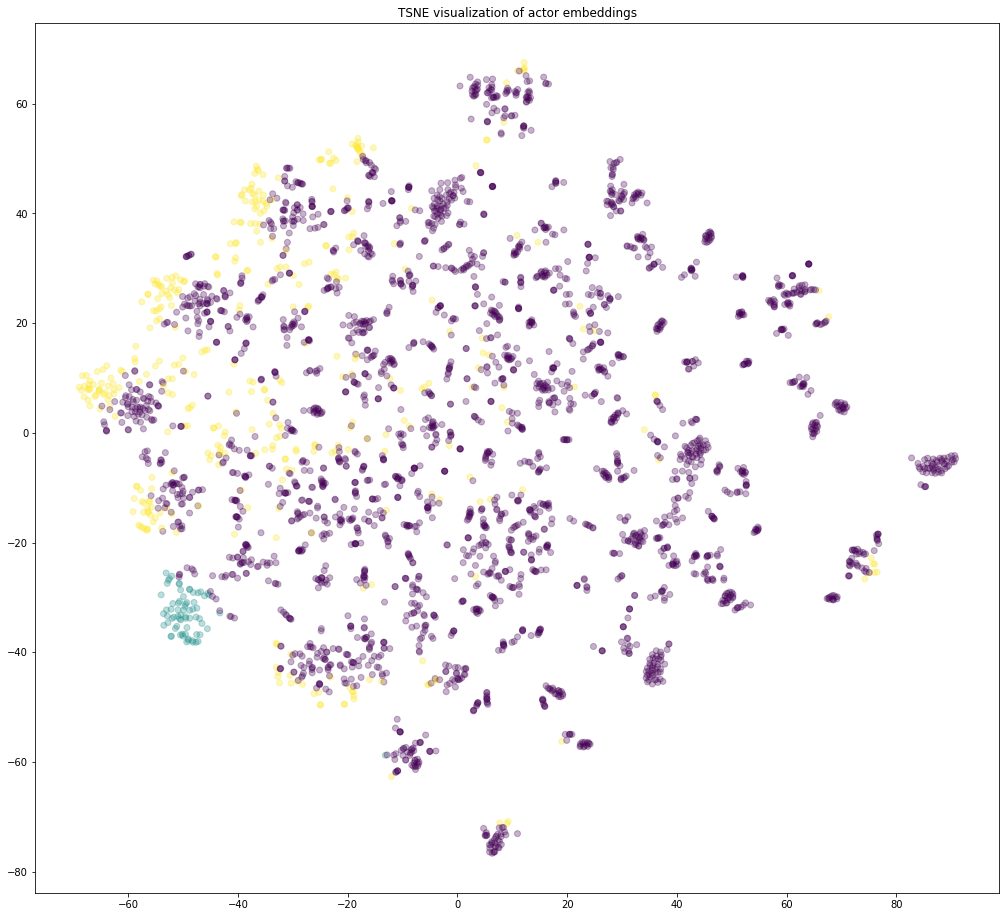

In [ ]:
import numpy as np
# draw the points

label_map = { l: i for i, l in enumerate(np.unique(p))}
node_colours = [ label_map[target] for target in p]

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(actor_embeddings_2d[:,0], 
            actor_embeddings_2d[:,1], 
            c=node_colours, alpha=0.3)
plt.title('{} visualization of actor embeddings'.format(transform.__name__))

plt.show()

#Task 2

<font color='orange'>Grouping similar movies</font>

In [ ]:
def cost1(graph,number_of_clusters):
  h = list(nx.connected_component_subgraphs(graph))
  t=len(h)
  degree=[]
  for i in range(t):
    su_graph=list(nx.connected_component_subgraphs(graph))[i]
    degree.append(su_graph.number_of_nodes())
  s=max(degree)
  f=graph.number_of_nodes()
  cost1=(1/number_of_clusters)*(s/f)
  return cost1

In [ ]:
def cost2(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    t=graph.number_of_edges()
    actor_nodes,movie_nodes=split_nodes(list(graph.nodes()))
    length=len(actor_nodes)
    cost2=(1/number_of_clusters)*(t/length) # calculate cost1 
    
    return cost2

In [ ]:
actor_nodes,movie_nodes=split_nodes(node_ids)

In [ ]:
cost=[]
k=[3, 5, 10, 30, 50, 100, 200, 500]
for i in k:
  est=KMeans(n_clusters=i).fit(np.array(movie_embeddings))
  cost1_cl=0
  cost2_cl=0
  for j in range(est.n_clusters):
    # Getting movie nodes at each cluster
    clus_act=np.take(movie_nodes, np.where(est.labels_==j)[0])
    G=nx.Graph()    # empty graph 
    for act in clus_act:
      sub_gr=nx.ego_graph(A, act)
      G.add_nodes_from(sub_gr.nodes)
      G.add_edges_from(sub_gr.edges())
    #nx.draw_networkx(G,node_color='red')
    cost1_cl+=cost1(G, i)
    cost2_cl+=cost2(G, i)
    cost_t=cost1_cl*cost2_cl
  cost.append(cost_t)
print(cost)

[2.7365971559835747, 2.504912060692, 2.3863945996093054, 2.1082114122666957, 1.843539951048348, 1.5324229941755834, 1.3598832542674482, 1.2084966877682741]


In [ ]:
optimal_cluster=3
est=KMeans(n_clusters=optimal_cluster).fit(np.array(movie_embeddings))
p=est.labels_

In [ ]:
from sklearn.manifold import TSNE
transform = TSNE #PCA

trans = transform(n_components=2)
movie_embeddings_2d = trans.fit_transform(movie_embeddings)

<font color='orange'>Displaying similar movie clusters</font>

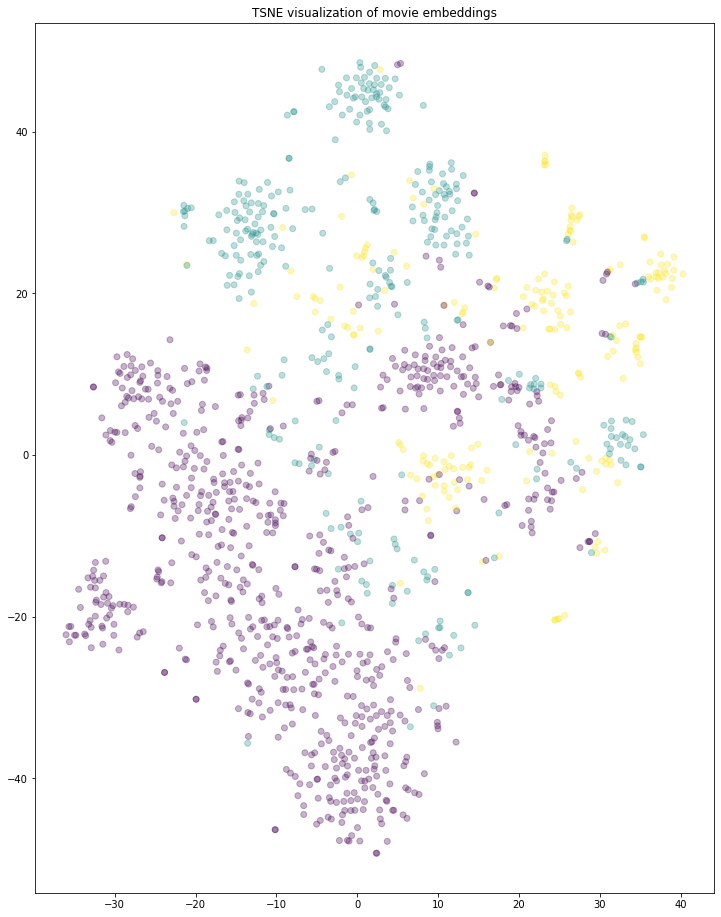

In [ ]:
import numpy as np
# draw the points

label_map = { l: i for i, l in enumerate(np.unique(p))}
node_colours = [ label_map[target] for target in p]

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(movie_embeddings_2d[:,0], 
            movie_embeddings_2d[:,1], 
            c=node_colours, alpha=0.3)
plt.title('{} visualization of movie embeddings'.format(transform.__name__))

plt.show()

#End